In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import pickle
import os
import torch.nn.functional as F
import requests
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd
torch.manual_seed(1) # Set manual seed
from sklearn import preprocessing
from torch.utils.data import DataLoader, Dataset, Subset

from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


IMAGE_SIZE = 32

mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

composed_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Resize the image in a 32X32 shape
                                     transforms.RandomRotation(20), # Randomly rotate some images by 20 degrees
                                     transforms.RandomHorizontalFlip(0.1), # Randomly horizontal flip the images
                                     transforms.ColorJitter(brightness = 0.1, # Randomly adjust color jitter of the images
                                                            contrast = 0.1,
                                                            saturation = 0.1),
                                     transforms.RandomAdjustSharpness(sharpness_factor = 2,
                                                                      p = 0.1), # Randomly adjust sharpness
                                     transforms.ToTensor(),   # Converting image to tensor
                                     transforms.Normalize(mean, std), # Normalizing with standard mean and standard deviation
                                     transforms.RandomErasing(p=0.75,scale=(0.02, 0.1),value=1.0, inplace=False)])


composed_test = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])

In [ ]:
batch_size = 100
valid_size= 0.2

# train_dataset =  dsets.CIFAR10(root='/content/drive/MyDrive/cifar10', train=True, download=True, transform = composed_train)
# validation_dataset = dsets.CIFAR10(root='/content/drive/MyDrive/cifar10', train=False, download=True, transform = composed_test)

# # Create train and validation batch for training
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
# validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100)


train_data= dsets.CIFAR10('/content/drive/MyDrive/cifar10', train= True,
                             download= True, transform = composed_train)
test_data = dsets.CIFAR10('/content/drive/MyDrive/cifar10', train = False,
                             download = True, transform= composed_test)

# Obtaining training Indices that we are going to use for Validation Set
num_train= len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:] , indices[:split]

# Defining samplers for training and validation Bathces
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Preparing Data Loader for all three sets (combining datasets and samplers)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size ,
                                           sampler= train_sampler )
valid_loader= torch.utils.data.DataLoader(train_data , batch_size= batch_size,
                                          sampler = valid_sampler)
test_loader= torch.utils.data.DataLoader(test_data, batch_size= batch_size)


Files already downloaded and verified
Files already downloaded and verified


Define common model training module

In [ ]:
def train_model(model, train_loader, validation_loader, optimizer, n_epochs = 20):

    # Global variable
    N_test = len(train_data)*valid_size
    accuracy_list = []
    train_loss_list = []
    train_cost_list = []
    val_cost_list = []

    for epoch in range(n_epochs):
        train_COST = 0
        for x,y in train_loader:
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z,y)
            loss.backward()
            optimizer.step()
            train_COST+=loss.item()

        train_COST = train_COST/len(train_loader)
        train_cost_list.append(train_COST)
        correct = 0

        # Perform the prediction on the validation data
        val_COST = 0
        for x_test, y_test in validation_loader:
            model.eval()
            z = model(x_test)
            val_loss = criterion(z, y_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat==y_test).sum().item()
            val_COST+=val_loss.item()

        val_COST = val_COST/ len(validation_loader)
        val_cost_list.append(val_COST)

        accuracy = correct / N_test
        accuracy_list.append(accuracy)

        print("--> Epoch Number : {}".format(epoch + 1),
              " | Training Loss : {}".format(round(train_COST,4)),
              " | Validation Loss : {}".format(round(val_COST,4)),
              " | Validation Accuracy : {}%".format(round(accuracy * 100, 2)))

    return accuracy_list, train_cost_list, val_cost_list

## 1)

In [ ]:
class CNN(nn.Module):
    def __init__(self, out_1 = 32, out_2 = 64, out_3 = 128, number_of_classes = 10, p = 0):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)

        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)

        self.cnn3 = nn.Conv2d(in_channels = out_2, out_channels = out_3, kernel_size = 5, padding = 2)
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2)

        # Hidden layer 1
        self.fc1 = nn.Linear(out_3 * 4 * 4, 1000)
        # 8x8 will change to 4x4 as we added a convolution & max pool layer refer calculation comment above
        self.drop = nn.Dropout(p=p)

        # Hidden layer 2
        self.fc2 = nn.Linear(1000, 1000)

        # Final layer
        self.fc3 = nn.Linear(1000, 10)

    # Predictiona
    def forward(self, x):

        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)

        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)

        x = self.cnn3(x)
        x = torch.relu(x)
        x = self.maxpool3(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        x = F.relu(self.drop(x))
        x = self.fc2(x)

        x = F.relu(self.drop(x))
        x = self.fc3(x)

        return(x)

In [ ]:
model= CNN(out_1=32, out_2=64, out_3 =128, number_of_classes = 10, p=0.5)

# Define the model hyperparameters
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.2)

# Train the model
accuracy_list, train_cost_list, val_cost_list=train_model(model=model, n_epochs=20, train_loader=train_loader, validation_loader=valid_loader, optimizer=optimizer)

--> Epoch Number : 1  | Training Loss : 1.9813  | Validation Loss : 1.7227  | Validation Accuracy : 37.49%
--> Epoch Number : 2  | Training Loss : 1.6029  | Validation Loss : 1.4405  | Validation Accuracy : 47.74%
--> Epoch Number : 3  | Training Loss : 1.4218  | Validation Loss : 1.4238  | Validation Accuracy : 48.66%
--> Epoch Number : 4  | Training Loss : 1.2924  | Validation Loss : 1.3414  | Validation Accuracy : 51.92%
--> Epoch Number : 5  | Training Loss : 1.1924  | Validation Loss : 1.1442  | Validation Accuracy : 60.11%
--> Epoch Number : 6  | Training Loss : 1.1066  | Validation Loss : 1.1141  | Validation Accuracy : 61.28%
--> Epoch Number : 7  | Training Loss : 1.0491  | Validation Loss : 1.0916  | Validation Accuracy : 61.98%
--> Epoch Number : 8  | Training Loss : 0.9926  | Validation Loss : 1.0175  | Validation Accuracy : 64.46%
--> Epoch Number : 9  | Training Loss : 0.9526  | Validation Loss : 0.971  | Validation Accuracy : 66.11%
--> Epoch Number : 10  | Training Loss

In [ ]:
pickle.dump(model, open('/content/drive/MyDrive/cifar10/CNN.pkl', 'wb'))

In [ ]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('/content/drive/MyDrive/cifar10/CNN.pt') # Save
model_scripted.save('./CNN.pt')

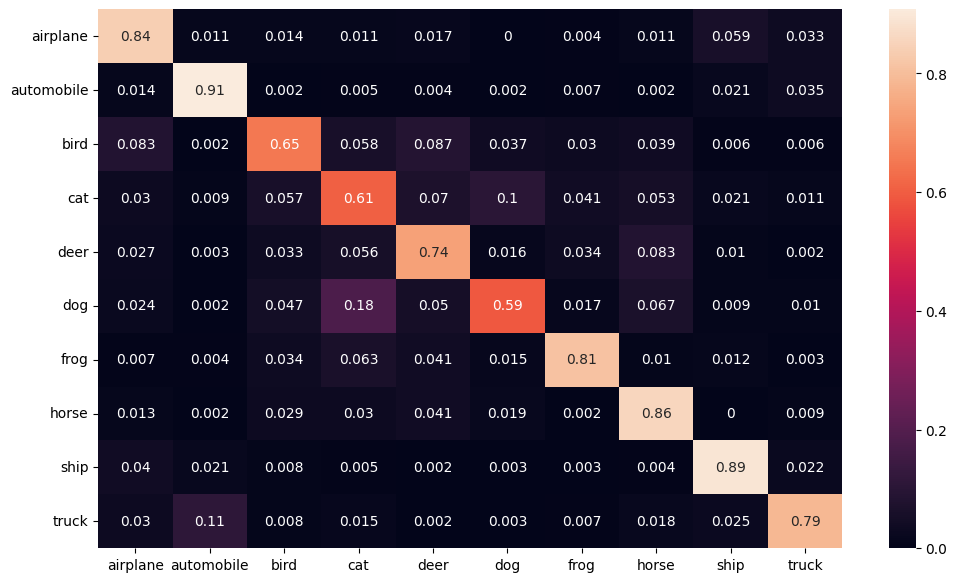

In [ ]:
from sklearn.metrics import accuracy_score


y_pred = []
y_true = []

classes = ('airplane',
           'automobile',
           'bird',
           'cat',
           'deer',
           'dog',
           'frog',
           'horse',
           'ship',
           'truck')


# iterate over test data
for x, y in test_loader:

    z = model(x)
    _, yhat = torch.max(z, 1)
    pred = yhat.data.cpu().numpy()
    y_pred.extend(pred) # Save Prediction

    labels = y.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [ ]:
print(f'confusion_matrix: \n{cf_matrix}\n accuracy:{acc}')

confusion_matrix: 
[[840  11  14  11  17   0   4  11  59  33]
 [ 14 908   2   5   4   2   7   2  21  35]
 [ 83   2 652  58  87  37  30  39   6   6]
 [ 30   9  57 606  70 102  41  53  21  11]
 [ 27   3  33  56 736  16  34  83  10   2]
 [ 24   2  47 183  50 591  17  67   9  10]
 [  7   4  34  63  41  15 811  10  12   3]
 [ 13   2  29  30  41  19   2 855   0   9]
 [ 40  21   8   5   2   3   3   4 892  22]
 [ 30 107   8  15   2   3   7  18  25 785]]
 accuracy:0.7676


## 2

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=5, stride=1, padding=2)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.relu(residual)
        residual = self.conv2(residual)

        return x + residual


In [ ]:
class ResidualCNN(nn.Module):
    def __init__(self, out_1 = 32, out_2 = 64, out_3 = 128, number_of_classes = 10, p = 0):
        super(ResidualCNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.residual1 = ResidualBlock(out_1, out_1)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)

        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.residual2 = ResidualBlock(out_2, out_2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)

        self.cnn3 = nn.Conv2d(in_channels = out_2, out_channels = out_3, kernel_size = 5, padding = 2)
        self.residual3 = ResidualBlock(out_3, out_3)
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2)

        # Hidden layer 1
        self.fc1 = nn.Linear(out_3 * 4 * 4, 1000)
        # 8x8 will change to 4x4 as we added a convolution & max pool layer refer calculation comment above
        self.drop = nn.Dropout(p=p)

        # Hidden layer 2
        self.fc2 = nn.Linear(1000, 1000)

        # Final layer
        self.fc3 = nn.Linear(1000, 10)

    # Predictiona
    def forward(self, x):

        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.residual1(x)

        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = self.residual2(x)

        x = self.cnn3(x)
        x = torch.relu(x)
        x = self.maxpool3(x)
        x = self.residual3(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        x = F.relu(self.drop(x))
        x = self.fc2(x)

        x = F.relu(self.drop(x))
        x = self.fc3(x)

        return(x)

In [ ]:
res_model= ResidualCNN(out_1=32, out_2=64, out_3 =128, number_of_classes = 10, p=0.5)

# Define the model hyperparameters
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(res_model.parameters(), lr = learning_rate, momentum = 0.2)

# Train the model
accuracy_list, train_cost_list, val_cost_list=train_model(model=res_model, n_epochs=20, train_loader=train_loader, validation_loader=valid_loader, optimizer=optimizer)

--> Epoch Number : 1  | Training Loss : 1.9145  | Validation Loss : 1.7105  | Validation Accuracy : 38.3%
--> Epoch Number : 2  | Training Loss : 1.5057  | Validation Loss : 1.4142  | Validation Accuracy : 48.82%
--> Epoch Number : 3  | Training Loss : 1.3049  | Validation Loss : 1.177  | Validation Accuracy : 58.52%
--> Epoch Number : 4  | Training Loss : 1.1666  | Validation Loss : 1.0816  | Validation Accuracy : 61.46%
--> Epoch Number : 5  | Training Loss : 1.0577  | Validation Loss : 1.0369  | Validation Accuracy : 62.95%
--> Epoch Number : 6  | Training Loss : 0.9746  | Validation Loss : 0.9728  | Validation Accuracy : 66.3%
--> Epoch Number : 7  | Training Loss : 0.9096  | Validation Loss : 0.8989  | Validation Accuracy : 68.72%
--> Epoch Number : 8  | Training Loss : 0.8584  | Validation Loss : 0.8664  | Validation Accuracy : 69.45%
--> Epoch Number : 9  | Training Loss : 0.8121  | Validation Loss : 0.8781  | Validation Accuracy : 69.41%
--> Epoch Number : 10  | Training Loss :

In [ ]:
pickle.dump(res_model, open('/content/drive/MyDrive/cifar10/res_CNN.pkl', 'wb'))

model_scripted = torch.jit.script(res_model) # Export to TorchScript
model_scripted.save('/content/drive/MyDrive/cifar10/res_CNN.pt') # Save
model_scripted.save('./res_CNN.pt')

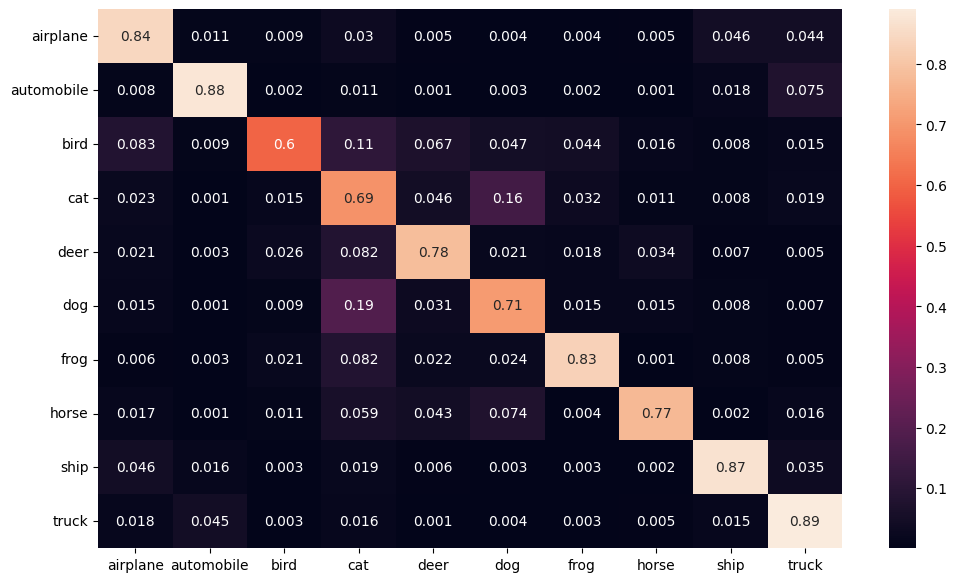

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = []
y_true = []

classes = ('airplane',
           'automobile',
           'bird',
           'cat',
           'deer',
           'dog',
           'frog',
           'horse',
           'ship',
           'truck')


# iterate over test data
for x, y in test_loader:

    z = res_model(x)
    _, yhat = torch.max(z, 1)
    pred = yhat.data.cpu().numpy()
    y_pred.extend(pred) # Save Prediction

    labels = y.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [ ]:
print(f'confusion_matrix: \n{cf_matrix}\n accuracy:{acc}')

confusion_matrix: 
[[842  11   9  30   5   4   4   5  46  44]
 [  8 879   2  11   1   3   2   1  18  75]
 [ 83   9 601 110  67  47  44  16   8  15]
 [ 23   1  15 689  46 156  32  11   8  19]
 [ 21   3  26  82 783  21  18  34   7   5]
 [ 15   1   9 190  31 709  15  15   8   7]
 [  6   3  21  82  22  24 828   1   8   5]
 [ 17   1  11  59  43  74   4 773   2  16]
 [ 46  16   3  19   6   3   3   2 867  35]
 [ 18  45   3  16   1   4   3   5  15 890]]
 accuracy:0.7861
